> **Problem overview**

This challenge serves as final project for the "How to win a data science competition" Coursera course. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

In [2]:
# pandas options
pd.options.display.max_rows = 10

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [3]:
# acquiring training and testing data
df_train = pd.read_csv('../input/sales_train.csv')
df_test = pd.read_csv('../input/test.csv')

In [4]:
# acquiring supplemental information
df_items = pd.read_csv('../input/items.csv')
df_categories = pd.read_csv('../input/item_categories.csv')
df_shops = pd.read_csv('../input/shops.csv')

In [5]:
# visualize head of the training data
df_train.head(n=5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
# visualize tail of the testing data
df_test.tail(n=5)

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [7]:
# visualize head of the supplemental information about the items/products
df_items.head(n=5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
# visualize head of the supplemental information about the items categories
df_categories.head(n=5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
# visualize head of the supplemental information about the shops
df_shops.head(n=5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train.insert(0, 'ID', np.nan)
df_test.insert(1, 'date', '01.11.2015')
df_test.insert(2, 'date_block_num', 34)
df_test.insert(df_test.shape[1] - 1, 'item_price', np.nan)
df_test.insert(df_test.shape[1] - 1, 'item_cnt_day', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=False)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [11]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [12]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [13]:
# boxplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [14]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [15]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [16]:
# violinplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [17]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [18]:
# describe training and testing data
df_data.describe(include='all')

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datatype
count,214200.00,3150049,3.150049e+06,3.150049e+06,3.150049e+06,2.935849e+06,2.935849e+06,3150049
unique,NaN,1035,NaN,NaN,NaN,NaN,NaN,2
top,NaN,01.11.2015,NaN,NaN,NaN,NaN,NaN,training
freq,NaN,214200,NaN,NaN,NaN,NaN,NaN,2935849
mean,107099.50,NaN,1.589114e+01,3.290933e+01,1.025313e+04,8.908532e+02,1.242641e+00,NaN
...,...,...,...,...,...,...,...,...
min,0.00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,NaN
25%,53549.75,NaN,7.000000e+00,2.200000e+01,4.510000e+03,2.490000e+02,1.000000e+00,NaN
50%,107099.50,NaN,1.500000e+01,3.100000e+01,9.461000e+03,3.990000e+02,1.000000e+00,NaN
75%,160649.25,NaN,2.400000e+01,4.700000e+01,1.572700e+04,9.990000e+02,1.000000e+00,NaN


In [19]:
# feature extraction: merge with supplemental information about the items/products
df_data = pd.merge(df_data, df_items, how='left', left_on='item_id', right_on='item_id')

In [20]:
# feature extraction: merge with supplemental information about the items categories
df_data = pd.merge(df_data, df_categories, how='left', left_on='item_category_id', right_on='item_category_id')

In [21]:
# feature extraction: merge with supplemental information about the shops
df_data = pd.merge(df_data, df_shops, how='left', left_on='shop_id', right_on='shop_id')

In [22]:
# convert dtypes numeric to object
col_convert = ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
df_data[col_convert] = df_data[col_convert].astype('object')

In [23]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['ID', 'item_price', 'item_cnt_day']
 length 3
features type object:
 items ['date', 'date_block_num', 'shop_id', 'item_id', 'datatype', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']
 length 9


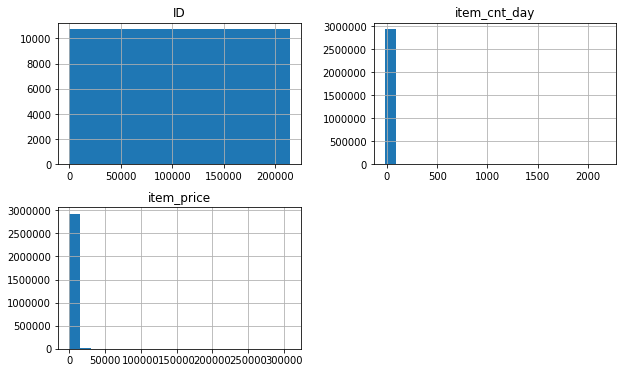

In [24]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [25]:
# feature exploration: item id
df_data['item_id'].value_counts()

20949    31382
5822      9450
17717     9109
2808      7521
4181      6895
         ...  
7080         1
7079         1
7063         1
7062         1
0            1
Name: item_id, Length: 22170, dtype: int64

In [26]:
# feature exploration: category id
df_data['item_category_id'].value_counts()

40    596992
55    367809
30    357303
19    214099
37    206576
       ...  
52         3
50         2
1          2
10         1
51         1
Name: item_category_id, Length: 84, dtype: int64

In [27]:
# feature exploration: shop id
df_data['shop_id'].value_counts()

31    240736
25    191204
28    147334
54    143480
57    122528
       ...  
40      4257
9       3751
8       3412
20      1792
11       499
Name: shop_id, Length: 60, dtype: int64

In [28]:
# feature exploration: item id 20949
df_items.loc[df_items['item_id'] == 20949, 'item_category_id']

20949    71
Name: item_category_id, dtype: int64

In [29]:
# feature exploration: category id 71
df_items.loc[df_items['item_category_id'] == 71, 'item_id']

7149      7149
13597    13597
13598    13598
20949    20949
21788    21788
21789    21789
Name: item_id, dtype: int64

In [30]:
# feature exploration: shop id 31
df_data.loc[df_data['shop_id'] == 31, 'item_category_id'].value_counts()

40    63005
55    30886
30    22112
37    15390
19    12040
      ...  
36        2
18        1
74        1
27        1
0         1
Name: item_category_id, Length: 74, dtype: int64

In [31]:
# feature exploration: category id 40
df_data.loc[df_data['item_category_id'] == 40, 'shop_id'].value_counts()

31    63005
25    38970
57    38290
54    35250
28    31022
      ...  
8       788
55      770
11       84
40       69
9         5
Name: shop_id, Length: 59, dtype: int64

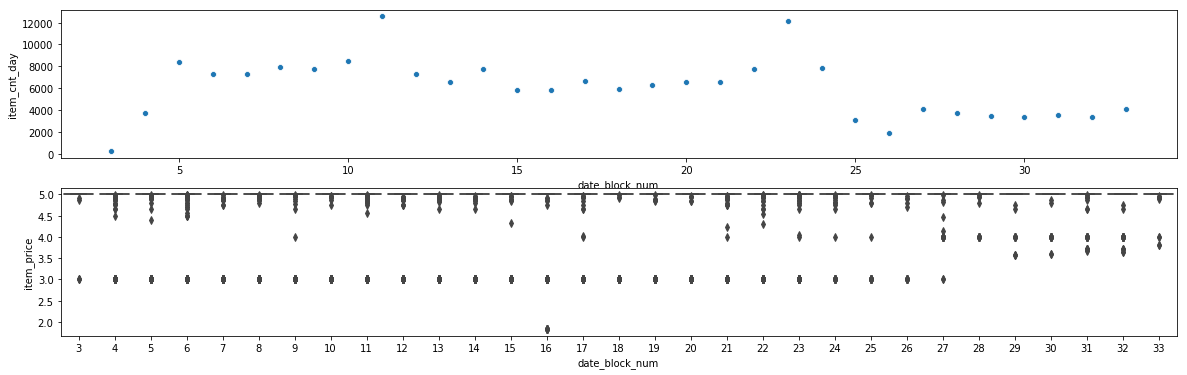

In [32]:
# feature exploration: item price and number of products sold by item id 20949
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_day', data=df_data[(df_data['item_id'] == 20949) & (df_data['datatype'] == 'training')].groupby(['date_block_num'], as_index=False).agg({'item_cnt_day': sum}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_data[(df_data['item_id'] == 20949) & (df_data['datatype'] == 'training')], ax=axes[1])

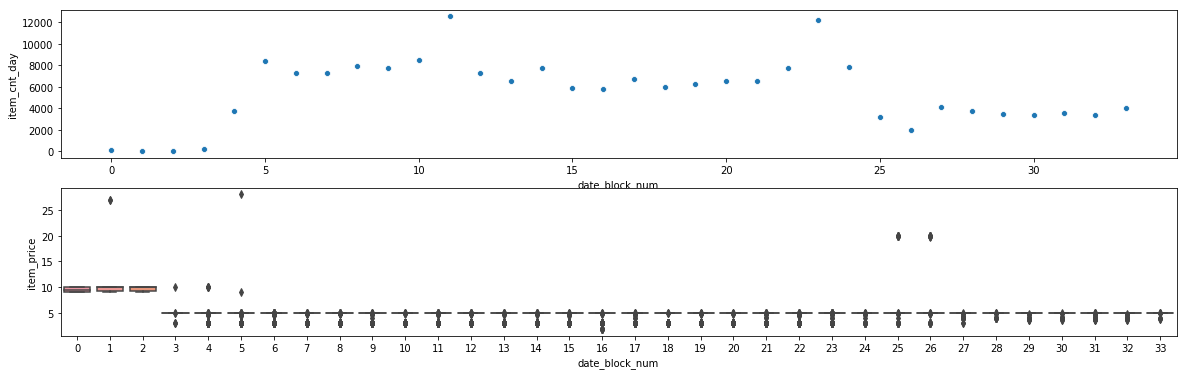

In [33]:
# feature exploration: item price and number of products sold by category id 71
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_day', data=df_data[(df_data['item_category_id'] == 71) & (df_data['datatype'] == 'training')].groupby(['date_block_num'], as_index=False).agg({'item_cnt_day': sum}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_data[(df_data['item_category_id'] == 71) & (df_data['datatype'] == 'training')], ax=axes[1])

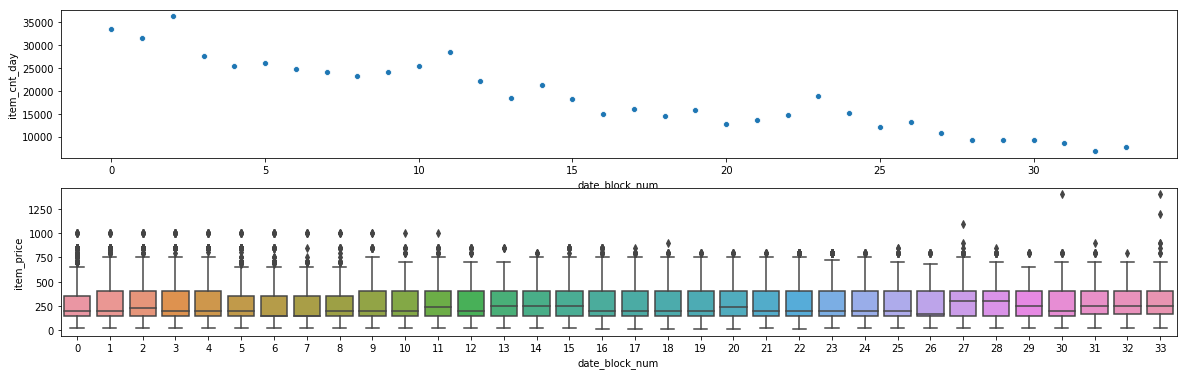

In [34]:
# feature exploration: item price and number of products sold by category id 40
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_day', data=df_data[(df_data['item_category_id'] == 40) & (df_data['datatype'] == 'training')].groupby(['date_block_num'], as_index=False).agg({'item_cnt_day': sum}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_data[(df_data['item_category_id'] == 40) & (df_data['datatype'] == 'training')], ax=axes[1])

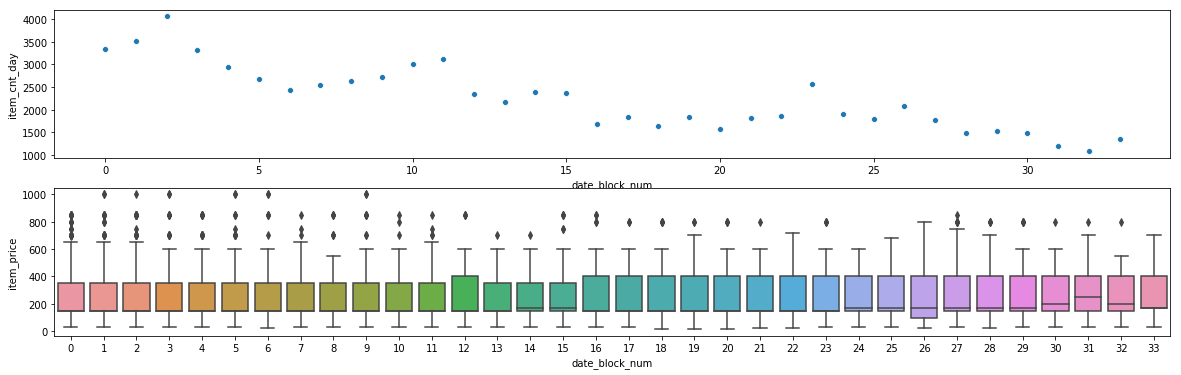

In [35]:
# feature exploration: item price and number of products sold by category id 40 and shop id 31
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_day', data=df_data[(df_data['item_category_id'] == 40) & (df_data['shop_id'] == 31) & (df_data['datatype'] == 'training')].groupby(['date_block_num'], as_index=False).agg({'item_cnt_day': sum}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_data[(df_data['item_category_id'] == 40) & (df_data['shop_id'] == 31) & (df_data['datatype'] == 'training')], ax=axes[1])

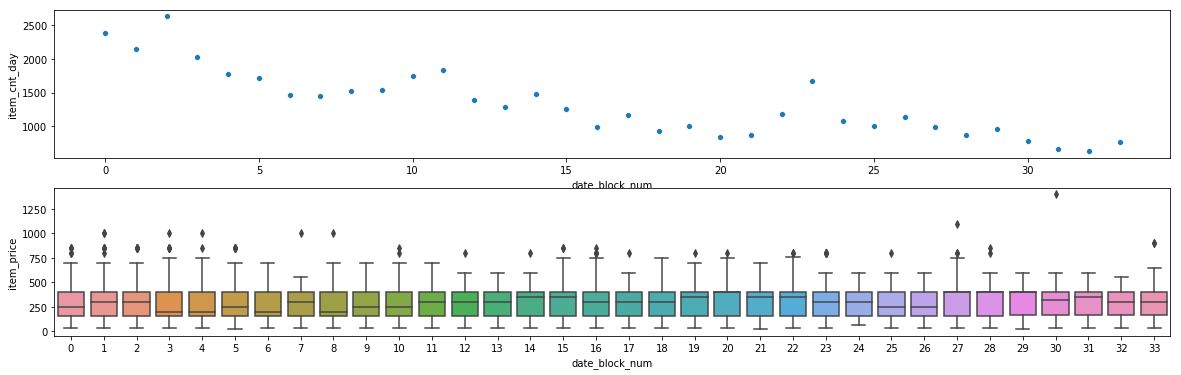

In [36]:
# feature exploration: item price and number of products sold by category id 40 and shop id 25
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_day', data=df_data[(df_data['item_category_id'] == 40) & (df_data['shop_id'] == 25) & (df_data['datatype'] == 'training')].groupby(['date_block_num'], as_index=False).agg({'item_cnt_day': sum}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_data[(df_data['item_category_id'] == 40) & (df_data['shop_id'] == 25) & (df_data['datatype'] == 'training')], ax=axes[1])

The exploratory data analysis resulting in,

* **Item and category:** Some items have only few records with similar category id.
* **Date, shop, item price and number of products sold:** Each items and categories have their own trends with date.

In [37]:
# feature extraction: combination of keyword date
df_data['date'] = pd.to_datetime(df_data['date'], format='%d.%m.%Y')
df_data['year'] = df_data['date'].dt.year - 2013
df_data['quarter'] = df_data['date'].dt.quarter
df_data['month'] = df_data['date'].dt.month
df_data['weekofyear'] = df_data['date'].dt.weekofyear
df_data['dayofweek'] = df_data['date'].dt.dayofweek

In [38]:
# feature extraction: block dataframe
df_block = df_data.groupby(['date_block_num', 'shop_id', 'item_id', 'item_category_id'], as_index=False).agg({
    'item_price': 'mean', 'item_cnt_day': sum,
    'year': 'first', 'quarter': 'first', 'month': 'first', 'weekofyear': 'first'
}).rename(columns={'item_cnt_day': 'item_cnt_month'})

In [39]:
# describe block dataframe for month 0 - 33
df_block[df_block['date_block_num'] != 34].describe(include='all')

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,year,quarter,month,weekofyear
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.466479e+01,3.280585e+01,1.068099e+04,4.154192e+01,7.908847e+02,2.267200e+00,7.925151e-01,2.389544e+00,6.154612e+00,2.435330e+01
std,9.542322e+00,1.653701e+01,6.238883e+03,1.632365e+01,1.551605e+03,8.649882e+00,7.773326e-01,1.117859e+00,3.455231e+00,1.504610e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,6.000000e+00,2.100000e+01,5.045000e+03,3.000000e+01,1.990000e+02,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.100000e+01
50%,1.400000e+01,3.100000e+01,1.049700e+04,4.000000e+01,3.990000e+02,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,2.400000e+01
75%,2.300000e+01,4.700000e+01,1.606000e+04,5.500000e+01,8.985000e+02,2.000000e+00,1.000000e+00,3.000000e+00,9.000000e+00,3.700000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,8.300000e+01,3.079800e+05,2.253000e+03,2.000000e+00,4.000000e+00,1.200000e+01,5.200000e+01


In [40]:
# describe block dataframe for month 34
df_block[df_block['date_block_num'] == 34].describe(include='all')

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,year,quarter,month,weekofyear
count,214200.0,214200.000000,214200.000000,214200.000000,0.0,214200.0,214200.0,214200.0,214200.0,214200.0
mean,34.0,31.642857,11019.398627,46.309608,NaN,0.0,2.0,4.0,11.0,44.0
std,0.0,17.561933,6252.644590,16.716581,NaN,0.0,0.0,0.0,0.0,0.0
min,34.0,2.000000,30.000000,0.000000,NaN,0.0,2.0,4.0,11.0,44.0
25%,34.0,16.000000,5381.500000,37.000000,NaN,0.0,2.0,4.0,11.0,44.0
50%,34.0,34.500000,11203.000000,43.000000,NaN,0.0,2.0,4.0,11.0,44.0
75%,34.0,47.000000,16071.500000,58.000000,NaN,0.0,2.0,4.0,11.0,44.0
max,34.0,59.000000,22167.000000,83.000000,NaN,0.0,2.0,4.0,11.0,44.0


In [41]:
# feature extraction: item price fillna by shop id and category id from previous month
npshopids = df_block['shop_id'].unique()
npcategoryids = df_block['item_category_id'].unique()
for npshopid in npshopids:
    for npcategoryid in npcategoryids:
        df_condition33 = (df_block['date_block_num'] == 33) & (df_block['shop_id'] == npshopid) & (df_block['item_category_id'] == npcategoryid)
        df_condition34 = (df_block['date_block_num'] == 34) & (df_block['shop_id'] == npshopid) & (df_block['item_category_id'] == npcategoryid)
        df_block.loc[df_condition34, 'item_price'] = df_block.loc[df_condition34, 'item_price'].fillna(df_block.loc[df_condition33, 'item_price'].mean())

In [42]:
# feature extraction: item price fillna by category id from previous month
npcategoryids = df_block['item_category_id'].unique()
for npcategoryid in npcategoryids:
    df_condition33 = (df_block['date_block_num'] == 33) & (df_block['item_category_id'] == npcategoryid)
    df_condition34 = (df_block['date_block_num'] == 34) & (df_block['item_category_id'] == npcategoryid)
    df_block.loc[df_condition34, 'item_price'] = df_block.loc[df_condition34, 'item_price'].fillna(df_block.loc[df_condition33, 'item_price'].mean())

In [43]:
# feature extraction: item price fillna by category id
npcategoryids = df_block['item_category_id'].unique()
for npcategoryid in npcategoryids:
    df_condition = df_block['item_category_id'] == npcategoryid
    df_block.loc[df_condition, 'item_price'] = df_block.loc[df_condition, 'item_price'].fillna(df_block.loc[df_condition, 'item_price'].mean())

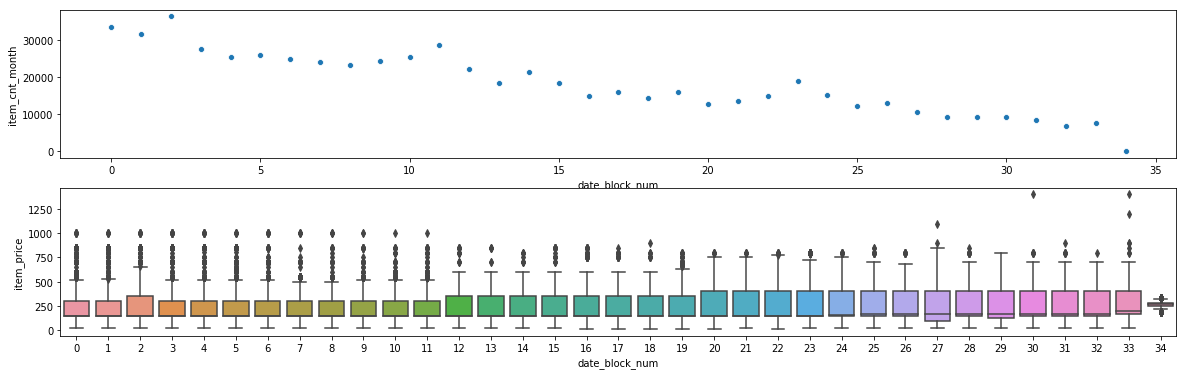

In [44]:
# feature exploration: item price and number of products sold by category id 40
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 40].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': sum}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 40], ax=axes[1])

In [45]:
# feature extraction: set maximum limit for number of products sold
df_block['item_cnt_month'] = df_block['item_cnt_month'].apply(lambda x: max(min(x, 20), 0))

In [46]:
# feature extraction: shifted features for number of products sold
for i in [1, 2, 3, 6, 12]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_cnt_month_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [47]:
# feature extraction: statistic features for category, shop and date block
for i in [1, 2, 3, 6, 12]:
    df_block['category_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean')
    df_block['category_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean')

In [48]:
# feature extraction: fillna with 0
col_fillnas = df_block.columns[df_block.isna().any()].tolist()
df_block[col_fillnas] = df_block[col_fillnas].fillna(0)

In [49]:
# feature extraction: drop first 12 months records
df_block = df_block[df_block['date_block_num'] > 11]

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [50]:
# describe block dataframe
df_block.describe(include='all')

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,year,quarter,month,weekofyear,item_cnt_month_shift1,item_cnt_month_shift2,item_cnt_month_shift3,item_cnt_month_shift6,item_cnt_month_shift12,category_date_mean_shift1,shop_date_mean_shift1,category_shop_date_mean_shift1,category_date_mean_shift2,shop_date_mean_shift2,category_shop_date_mean_shift2,category_date_mean_shift3,shop_date_mean_shift3,category_shop_date_mean_shift3,category_date_mean_shift6,shop_date_mean_shift6,category_shop_date_mean_shift6,category_date_mean_shift12,shop_date_mean_shift12,category_shop_date_mean_shift12
count,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06,1.135600e+06
mean,2.392030e+01,3.285749e+01,1.071334e+04,4.246623e+01,9.223044e+02,1.627938e+00,1.500225e+00,2.649064e+00,6.917606e+00,2.738129e+01,1.113019e+00,1.032718e+00,9.635646e-01,8.193061e-01,6.152659e-01,2.524615e+00,2.642792e+00,2.260644e+00,2.544256e+00,2.669386e+00,2.261384e+00,2.562295e+00,2.690098e+00,2.259242e+00,2.611154e+00,2.764666e+00,2.247157e+00,2.742345e+00,2.923402e+00,2.261651e+00
std,7.378039e+00,1.668530e+01,6.267448e+03,1.697598e+01,1.802877e+03,2.404500e+00,5.000002e-01,1.188202e+00,3.636417e+00,1.549692e+01,2.567816e+00,2.527247e+00,2.477855e+00,2.363099e+00,2.129682e+00,1.282661e+00,7.214142e-01,1.563338e+00,1.323560e+00,7.375879e-01,1.633253e+00,1.361805e+00,7.676066e-01,1.690772e+00,1.471257e+00,8.275120e-01,1.825281e+00,1.677096e+00,9.321831e-01,2.105133e+00
min,1.200000e+01,2.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.700000e+01,2.100000e+01,5.010000e+03,3.000000e+01,2.593767e+02,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.727993e+00,2.163934e+00,1.350000e+00,1.729373e+00,2.160494e+00,1.333333e+00,1.736536e+00,2.173077e+00,1.311475e+00,1.733333e+00,2.255814e+00,1.250000e+00,1.782732e+00,2.396755e+00,1.133333e+00
50%,2.400000e+01,3.100000e+01,1.051200e+04,4.000000e+01,3.995000e+02,1.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00,2.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.231826e+00,2.605442e+00,1.923077e+00,2.297985e+00,2.628049e+00,1.908046e+00,2.227191e+00,2.700321e+00,1.875000e+00,2.243363e+00,2.796020e+00,1.818182e+00,2.302469e+00,3.000000e+00,1.764706e+00
75%,3.100000e+01,4.800000e+01,1.605900e+04,5.500000e+01,1.032623e+03,2.000000e+00,2.000000e+00,4.000000e+00,1.100000e+01,4.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,3.030864e+00,3.088889e+00,2.875000e+00,3.003904e+00,3.121641e+00,2.886792e+00,3.015686e+00,3.162075e+00,2.906977e+00,3.139344e+00,3.273994e+00,2.913043e+00,3.272527e+00,3.487500e+00,2.956522e+00
max,3.400000e+01,5.900000e+01,2.216900e+04,8.300000e+01,5.099900e+04,2.000000e+01,2.000000e+00,4.000000e+00,1.200000e+01,5.200000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,5.293785e+00,2.000000e+01,2.000000e+01,6.000000e+00,2.000000e+01,2.000000e+01,5.021978e+00,2.000000e+01,2.000000e+01,8.000000e+00,2.000000e+01,2.000000e+01,9.770270e+00,2.000000e+01


In [51]:
# verify dtypes object
df_block.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135600 entries, 687724 to 1823323
Data columns (total 30 columns):
date_block_num                     1135600 non-null int64
shop_id                            1135600 non-null int64
item_id                            1135600 non-null int64
item_category_id                   1135600 non-null int64
item_price                         1135600 non-null float64
item_cnt_month                     1135600 non-null float64
year                               1135600 non-null int64
quarter                            1135600 non-null int64
month                              1135600 non-null int64
weekofyear                         1135600 non-null int64
item_cnt_month_shift1              1135600 non-null float64
item_cnt_month_shift2              1135600 non-null float64
item_cnt_month_shift3              1135600 non-null float64
item_cnt_month_shift6              1135600 non-null float64
item_cnt_month_shift12             1135600 non-null float6

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

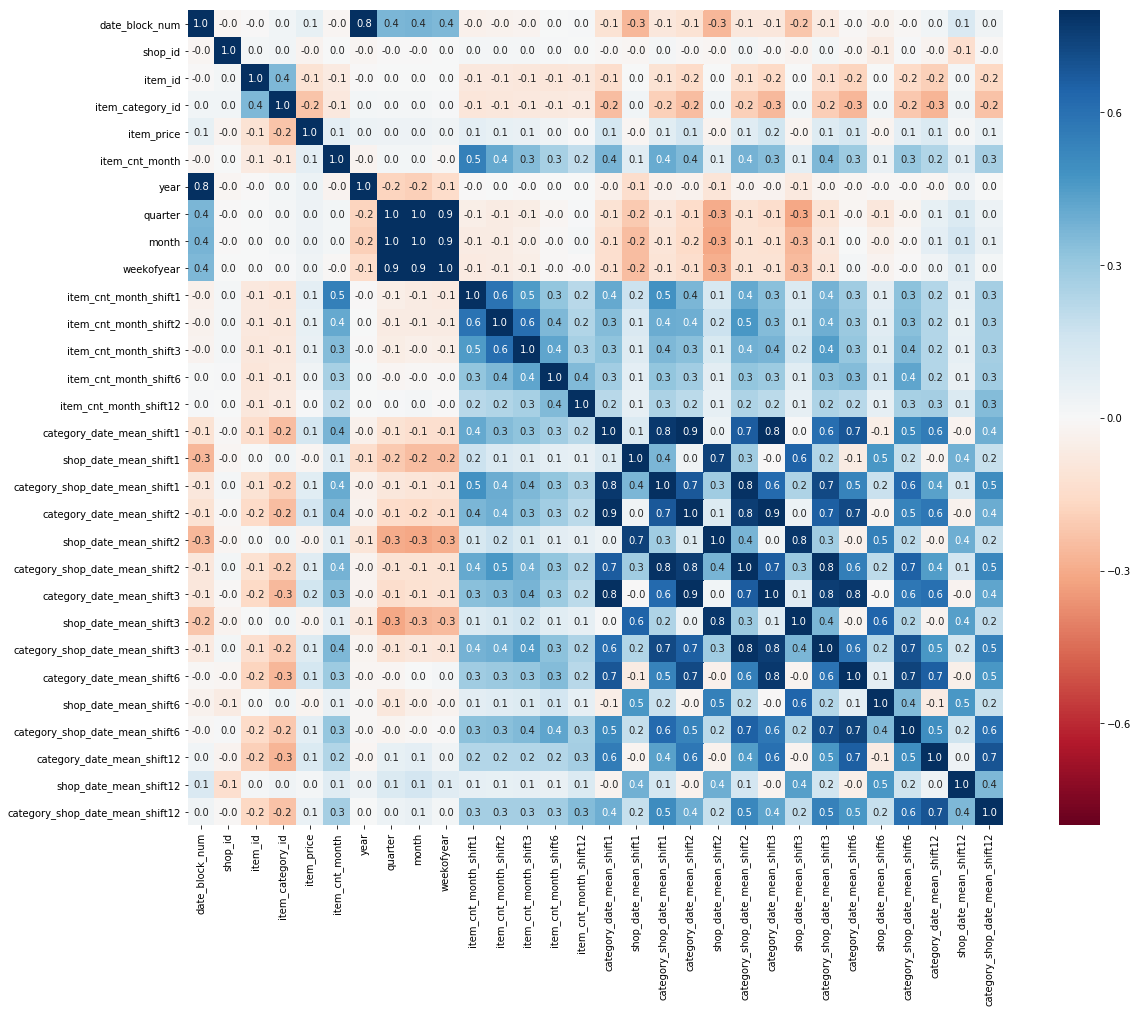

In [52]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_block[df_block['date_block_num'] != 34].corr()
fig, axes = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [53]:
# select all features
x = df_block[df_block['date_block_num'] != 34].drop(['item_cnt_month', 'year'], axis=1)
y = df_block.loc[df_block['date_block_num'] != 34]['item_cnt_month']

In [54]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

In [55]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(booster='gbtree', learning_rate=0.1, n_estimators=1000, objective='reg:linear', random_state=58,
                                colsample_bytree=0.9, max_depth=8, reg_alpha=0.1, reg_lambda=0.9, subsample=0.9)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, early_stopping_rounds=50, eval_set=[(x_validate, y_validate)], verbose=False,
                 callbacks=[xgb.callback.print_evaluation(period=50)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:2.7826
[50]	validation_0-rmse:1.74345
[100]	validation_0-rmse:1.64821
[150]	validation_0-rmse:1.60135
[200]	validation_0-rmse:1.57442
[250]	validation_0-rmse:1.54747
[300]	validation_0-rmse:1.53302
[350]	validation_0-rmse:1.52273
[400]	validation_0-rmse:1.50835
[450]	validation_0-rmse:1.49942
[500]	validation_0-rmse:1.49301
[550]	validation_0-rmse:1.48745
[600]	validation_0-rmse:1.47931
[650]	validation_0-rmse:1.47348
[700]	validation_0-rmse:1.46823
[750]	validation_0-rmse:1.46446
[800]	validation_0-rmse:1.46047
[850]	validation_0-rmse:1.45683
[900]	validation_0-rmse:1.4536
[950]	validation_0-rmse:1.4493
[999]	validation_0-rmse:1.44607
xgboost regression
  root mean squared error: 1.4462


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [56]:
# model selection
final_model = model_xgbreg

# prepare testing data and compute the observed value
x_test = df_block[df_block['date_block_num'] == 34].drop(['item_cnt_month', 'year'], axis=1)
y_test = pd.DataFrame({'item_cnt_month': final_model.predict(x_test), 'shop_id': x_test['shop_id'], 'item_id': x_test['item_id']}, index=x_test.index)
y_test = pd.merge(y_test, df_test[['ID', 'shop_id', 'item_id']], how='left', on=['shop_id', 'item_id'])

In [57]:
# summit the results
out = pd.DataFrame({'ID': y_test['ID'], 'item_cnt_month': y_test['item_cnt_month']})
out.to_csv('submission.csv', index=False)